## Sport Analytics NBA Dataset
###### Question: Your homework will be to pick a sport and build a Bayesian model on the sport or on select teams, and be able to do some predictions. You need to base your model on a simple linear combination of independent variables, in order to be able to get a better handle on a dependent variable. You can use a simple linear model, a log-linear model, or a linear-logistic model. DON'T copy from the Web. Do your own study. Non-significant results is accepted, as long as you explain why you think the effort failed. You will need to explain how you build model and choose distribution, what does the plot indicate and how these plot lead to your final conclusion during the code review. So comment as much as you can.

### Importing Libraries

In [68]:
import numpy as np
import pandas as pd
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
import pymc3 as pm, theano.tensor as tt
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
%matplotlib inline

In [69]:
nba_Df = pd.read_csv("./data/nbaallelo.csv")

In [70]:
nba_Df.tail()

,gameorder,game_id,lg_id,_iscopy,year_id,date_game,seasongame,is_playoffs,team_id,fran_id,...,win_equiv,opp_id,opp_fran,opp_pts,opp_elo_i,opp_elo_n,game_location,game_result,forecast,notes
126309,63155,201506110CLE,NBA,0,2015,6/11/2015,100,1,CLE,Cavaliers,...,60.309792,GSW,Warriors,103,1790.9591,1809.9791,H,L,0.546572,NaN
126310,63156,201506140GSW,NBA,0,2015,6/14/2015,102,1,GSW,Warriors,...,68.013329,CLE,Cavaliers,91,1704.3949,1700.7391,H,W,0.765565,NaN
126311,63156,201506140GSW,NBA,1,2015,6/14/2015,101,1,CLE,Cavaliers,...,60.010067,GSW,Warriors,104,1809.9791,1813.6349,A,L,0.234435,NaN
126312,63157,201506170CLE,NBA,0,2015,6/16/2015,102,1,CLE,Cavaliers,...,59.290245,GSW,Warriors,105,1813.6349,1822.2881,H,L,0.481450,NaN
126313,63157,201506170CLE,NBA,1,2015,6/16/2015,103,1,GSW,Warriors,...,68.519516,CLE,Cavaliers,97,1700.7391,1692.0859,A,W,0.518550,NaN


## Data exploration

### So this data set basically has the elo rating of each NBA team for every game played from the year 1947 till 2015. That's a lot of games!! 

### Elo Ratings System is a method for calculating the relative skill levels of players in zero-sum games such as chess. It is named after its creator Arpad Elo, a Hungarian-American physics professor. 
### The Elo system was originally invented as an improved chess rating system over the previously used Harkness system, but is also used as a rating system for multiplayer competition in a number of video games, association football, American football, basketball, Major League Baseball, table tennis, Scrabble, board games such as Diplomacy and other games.

### For more info on Elo click here:
https://en.wikipedia.org/wiki/Elo_rating_system

In [71]:
nba_Df = nba_Df.drop(columns=["gameorder","lg_id","game_id","is_playoffs"])
#nba_Df.head()
nba_Df = nba_Df[nba_Df["_iscopy"] == 1]
nba_Df.head()

,_iscopy,year_id,date_game,seasongame,team_id,fran_id,pts,elo_i,elo_n,win_equiv,opp_id,opp_fran,opp_pts,opp_elo_i,opp_elo_n,game_location,game_result,forecast,notes
1,1,1947,11/1/1946,1,NYK,Knicks,68,1300.0000,1306.7233,41.705170,TRH,Huskies,66,1300.0,1293.2767,A,W,0.359935,NaN
3,1,1947,11/2/1946,2,NYK,Knicks,47,1306.7233,1297.0712,40.692783,CHS,Stags,63,1300.0,1309.6521,A,L,0.368899,NaN
5,1,1947,11/2/1946,1,WSC,Capitols,50,1300.0000,1320.3811,43.135952,DTF,Falcons,33,1300.0,1279.6189,A,W,0.359935,NaN
6,1,1947,11/2/1946,1,BOS,Celtics,53,1300.0000,1294.8458,40.459381,PRO,Steamrollers,59,1300.0,1305.1542,A,L,0.359935,NaN
8,1,1947,11/2/1946,1,PIT,Ironmen,51,1300.0000,1295.3092,40.507980,STB,Bombers,56,1300.0,1304.6908,A,L,0.359935,NaN


In [72]:
print(len(nba_Df))
for col in nba_Df.columns: 
    print(col) 

63157
_iscopy
year_id
date_game
seasongame
team_id
fran_id
pts
elo_i
elo_n
win_equiv
opp_id
opp_fran
opp_pts
opp_elo_i
opp_elo_n
game_location
game_result
forecast
notes


## Let's reduce the number of games to save some time in our computing! We will consider only the 2015 season and try to find out which team will win the season based on elo rating of the team.

In [73]:
nba_Df = nba_Df[nba_Df["year_id"] == 2015]
len(nba_Df)

1311

In [74]:
[game_id for game_id in list(zip(nba_Df['team_id'], 
                                 nba_Df['opp_id'], nba_Df['game_location'],nba_Df["elo_i"],
                                 nba_Df["opp_elo_i"]))]

[('HOU', 'LAL', 'A', 1596.4641, 1421.9985),
 ('ORL', 'NOP', 'A', 1359.4265, 1457.2185),
 ('DAL', 'SAS', 'A', 1592.0101, 1699.5024),
 ('BRK', 'BOS', 'A', 1518.2666, 1378.5464),
 ('MIL', 'CHO', 'A', 1317.8491, 1511.0031),
 ('DET', 'DEN', 'A', 1389.2994, 1473.0493),
 ('PHI', 'IND', 'A', 1316.4243, 1532.6748),
 ('MIN', 'MEM', 'A', 1513.3354, 1578.4064),
 ('WAS', 'MIA', 'A', 1541.4388, 1579.3748),
 ('CHI', 'NYK', 'A', 1547.2185, 1534.4419),
 ('LAL', 'PHO', 'A', 1410.6588, 1560.1208),
 ('OKC', 'POR', 'A', 1619.7805, 1567.8318),
 ('GSW', 'SAC', 'A', 1590.7976, 1431.1567),
 ('ATL', 'TOR', 'A', 1490.1147, 1550.7469),
 ('HOU', 'UTA', 'A', 1607.8038, 1373.317),
 ('NYK', 'CLE', 'A', 1509.5001, 1463.7213),
 ('UTA', 'DAL', 'A', 1367.0422, 1590.3984),
 ('OKC', 'LAC', 'A', 1607.6138, 1630.6335),
 ('DET', 'MIN', 'A', 1384.6356, 1510.2198),
 ('WAS', 'ORL', 'A', 1534.9141, 1353.2910000000002),
 ('CLE', 'CHI', 'A', 1455.226, 1572.1603),
 ('MEM', 'IND', 'A', 1581.5220000000002, 1535.2634),
 ('LAC', 'LAL', 

In [75]:
df_elo_i_count = nba_Df.groupby('team_id')['elo_i'].count()

df_elo_i_sum = nba_Df.groupby('team_id')['elo_i'].sum()
#df_elo_n_sum = nba_Df.groupby('team_id')['elo_n'].sum()
df_opp_elo_i_sum = nba_Df.groupby('team_id')['opp_elo_i'].sum()
#df_opp_elo_n_sum = nba_Df.groupby('team_id')['opp_elo_i'].sum()

df_elo_i_var = nba_Df.groupby('team_id')['elo_i'].var()
#df_elo_n_var = nba_Df.groupby('team_id')['elo_n'].var()
df_opp_elo_i_var = nba_Df.groupby('team_id')['opp_elo_i'].var()
#df_opp_elo_n_var = nba_Df.groupby('team_id')['opp_elo_i'].var()

df_elo_i_var

team_id
ATL    3445.348169
BOS    2030.129132
BRK     772.180736
CHI     651.526971
CHO    1066.858241
CLE    7594.095063
DAL     620.175133
DEN    1095.022635
DET    2698.408900
GSW    2895.229468
HOU     331.549020
IND     443.349334
LAC    1105.054845
LAL    1105.294652
MEM     733.732467
MIA    1656.495624
MIL    4048.427584
MIN    4404.063094
NOP     478.935435
NYK    6601.848464
OKC     925.206232
ORL     856.527700
PHI     512.768340
PHO    1032.474481
POR     567.311595
SAC    1434.334644
SAS    1495.522743
TOR    1092.077204
UTA    4447.415527
WAS    1072.083628
Name: elo_i, dtype: float64

In [82]:
df_team_mean = df_elo_i_sum/df_elo_i_count
df_team_std = np.sqrt( df_elo_i_var.fillna(0)/ df_elo_i_count )
df_team_mean.sort_values()

team_id
PHI    1282.647149
ORL    1342.670366
NYK    1354.053210
MIN    1368.153071
LAL    1375.890359
DET    1407.364949
SAC    1423.862127
BOS    1424.577870
UTA    1442.134863
MIL    1447.071980
DEN    1451.402812
CHO    1454.615483
BRK    1466.161750
IND    1475.121320
MIA    1488.834476
NOP    1500.136426
WAS    1536.546276
PHO    1538.777273
CHI    1565.855187
CLE    1570.065739
TOR    1573.042823
OKC    1582.493363
DAL    1599.326923
ATL    1606.797002
POR    1618.565073
MEM    1622.307965
HOU    1622.363778
LAC    1658.145192
SAS    1677.377204
GSW    1721.544263
Name: elo_i, dtype: float64

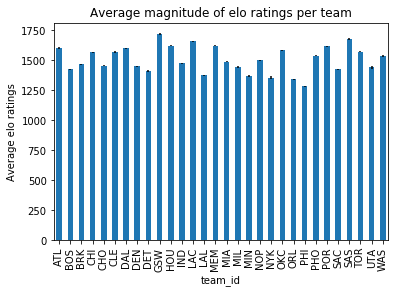

In [77]:
(df_team_mean

      .plot(kind='bar', title='Average magnitude of elo ratings per team', yerr=df_team_std)
      .set_ylabel('Average elo ratings'));

## Looks like the leading teams should be:
### GSW: Players included Steph Curry, Klay Thompson, Draymond Green
### SAS: Players included Tim Duncan, Kawhi Leonard, Tony Parker
### LAC: Players included Chris Paul, Blake Griffin, DeAndre Jordan (Team was AKA "Lob City" btw)
### HOU: Had James Harden (Fear the Beard!!)

In [83]:
df = nba_Df[['team_id','opp_id','elo_i', 'opp_elo_i']]
df.head()

,team_id,opp_id,elo_i,opp_elo_i
123692,HOU,LAL,1596.4641,1421.9985
123695,ORL,NOP,1359.4265,1457.2185
123697,DAL,SAS,1592.0101,1699.5024
123699,BRK,BOS,1518.2666,1378.5464
123700,MIL,CHO,1317.8491,1511.0031


## Resetting index of dataframe

In [84]:
df = df.reset_index()
df.head()

,index,team_id,opp_id,elo_i,opp_elo_i
0,123692,HOU,LAL,1596.4641,1421.9985
1,123695,ORL,NOP,1359.4265,1457.2185
2,123697,DAL,SAS,1592.0101,1699.5024
3,123699,BRK,BOS,1518.2666,1378.5464
4,123700,MIL,CHO,1317.8491,1511.0031


In [85]:
num_teams = len(nba_Df["team_id"])
print(num_teams)

1311


#### Indexing the teams

In [87]:
teams = df['team_id'].unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index
teams

,team,i
0,HOU,0
1,ORL,1
2,DAL,2
3,BRK,3
4,MIL,4
5,DET,5
6,PHI,6
7,MIN,7
8,WAS,8
9,CHI,9


In [88]:
df = pd.merge(df, teams, left_on='team_id', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_home'}).drop('team', 1)
df = pd.merge(df, teams, left_on='opp_id', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_away'}).drop('team', 1)
df.head()

,index,team_id,opp_id,elo_i,opp_elo_i,i_home,i_away
0,123692,HOU,LAL,1596.4641,1421.9985,0,10
1,123695,ORL,NOP,1359.4265,1457.2185,1,29
2,123697,DAL,SAS,1592.0101,1699.5024,2,19
3,123699,BRK,BOS,1518.2666,1378.5464,3,22
4,123700,MIL,CHO,1317.8491,1511.0031,4,28


i_ home is index of home team and i_away is index of away team

In [89]:
observed_home_elo = df['elo_i'].values
observed_away_elo = df['opp_elo_i'].values

home_team = df['i_home'].values
away_team = df['i_away'].values

num_teams = len(teams)
num_games = len(home_team)
num_teams, num_games

(30, 1311)

So 30 teams played 1311 games in 2015 NBA Season!

In [90]:
print(home_team)
print(away_team)

[ 0  1  2 ... 12 16 12]
[10 29 19 ... 16 12 16]


In [91]:
observed_home_elo = df['elo_i'].values
observed_home_elo

array([1596.4641, 1359.4265, 1592.0101, ..., 1790.9591, 1704.3949,
       1813.6349])

In [92]:
g1 = df.groupby('i_away')
att_starting_points = np.log(g1['opp_elo_i'].mean())
g2 = df.groupby('i_home')
def_starting_points = -np.log(g2['elo_i'].mean())
def_starting_points

i_home
0    -7.391639
1    -7.202416
2    -7.377338
3    -7.290403
4    -7.277297
5    -7.249474
6    -7.156681
7    -7.221217
8    -7.337292
9    -7.356187
10   -7.226856
11   -7.366757
12   -7.450977
13   -7.381998
14   -7.210858
15   -7.273880
16   -7.358873
17   -7.391605
18   -7.413455
19   -7.424987
20   -7.389295
21   -7.296496
22   -7.261631
23   -7.280286
24   -7.360767
25   -7.305749
26   -7.338743
27   -7.261128
28   -7.282497
29   -7.313311
Name: elo_i, dtype: float64

In [103]:
with pm.Model() as model:
    # global model priors: standard deviation and intercept.
    # We are saying that the standard deviation and intercept priors of each
    # team's elo and oppositions elo parameters stem from the same folded-t distribution.
    # Note use of student-t because we only have 30 teams, low number.
    sd_elo = pm.HalfStudentT('sd_elo', nu=1500, sd=400)
    sd_opp_elo = pm.HalfStudentT('sd_opp_elo', nu=1500, sd=400)
    home = pm.Flat('home') #flat pdf is uninformative - means we have no idea. But we want to give the home team some advantage so we keep this..
    intercept = pm.Flat('intercept') #no idea

    # team-specific model parameters. There is one (atts_star, defs_star) tuple per team.
    # Note use of normal distribution because we assume we have a lot of data per team
    # (not really here, but *you* should!)
    elo_star = pm.Normal("elo_star", mu=0, sd=sd_elo, shape=num_teams)
    opp_elo_star = pm.Normal("opp_elo_star", mu=0, sd=sd_opp_elo, shape=num_teams)

    # To allow samples of expressions to be saved, we need to wrap them in pymc3 Deterministic objects
    # We save these parameters for later exploration.
    elo = pm.Deterministic('elo', elo_star - tt.mean(elo_star))
    opp_elo = pm.Deterministic('opp_elo', opp_elo_star - tt.mean(opp_elo_star))
    
    # Assume exponential search on home_theta and away_theta. With pymc3, need to rely on theano.
    # tt is theano.tensor.. why Sampyl may be easier to use..
    home_theta = tt.exp(intercept + elo[home_team] + opp_elo[away_team])  
    away_theta = tt.exp(intercept + elo[away_team] + opp_elo[home_team])

    # likelihood of observed data, Poisson distribution for coutn data, always!
    home_points = pm.Poisson('home_points', mu=home_theta, observed=observed_home_elo)
    away_points = pm.Poisson('away_points', mu=away_theta, observed=observed_away_elo)
    
    
    
#     # Assume exponential search on home_theta and away_theta. With pymc3, need to rely on theano.
#     # tt is theano.tensor.. why Sampyl may be easier to use..
#     home_theta = tt.exp(intercept + home + atts[nba_Df["team_id"]] + defs[nba_Df["opp_id"]])  
#     away_theta = tt.exp(intercept + + atts[nba_Df["team_id"]] + defs[nba_Df["opp_id"]])

#     # likelihood of observed data, Poisson distribution for coutn data, always!
#     home_points = pm.Poisson('home_points', mu=home_theta, observed=nba_Df["elo_i"])
#     away_points = pm.Poisson('away_points', mu=away_theta, observed=nba_Df["opp_elo_i"])

In [104]:
with model:
    trace = pm.sample(1000, tune=1000, cores=2)
    pm.traceplot(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [opp_elo_star, elo_star, intercept, home, sd_opp_elo, sd_elo]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 4000/4000 [01:54<00:00, 34.99draws/s]
The acceptance probability does not match the target. It is 0.9192432984443321, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


ImportError: ArviZ is not installed. In order to use `plot_trace`:
pip install arviz

Arviz is installed though.. we tried debugging this error but had no luck so far.. Although this DOES NOT stop us from proceeding and seeing the accuracy of our model.. so we will continue..

## Plotting

Let's plot Team Elo strengths, with **credible intervals**, so we have uncertainty quantification of our estimate of teams' strengths.

In Bayesian statistics, a *credible interval* is a range of values within which an unobserved parameter value falls with a particular subjective probability. It is an interval in the domain of a posterior probability distribution or a predictive distribution.

Credible intervals are analogous to **confidence intervals** in the frequentist statistics

Bayesian intervals treat bounds as *fixed* and the estimated parameter as a *random variable*. In our experiment to determine the distribution of team strength `elo`, if the subjective probability that `elo`$_{GSW}$ lies between 0.35 and 0.55 is 0.95, then $0.35\leq \text{elo} \leq 0.55$ is a 95% credible interval.

Frequentist confidence intervals treat bounds as random variables and the parameter as a fixed value. A frequentist 95% confidence interval means that with a large number of repeated samples, 95% of such calculated confidence intervals would include the true value of the parameter. However, Bayesian credible intervals do require knowledge of a situation-specific prior distribution, while frequentist confidence intervals do not.

The **highest posterior density interval** (HDI) is the interval which contains the required point estimate such that all points within the interval have a higher probability density than points outside the interval. The HDI is the narrowest interval containing the specified point estimate. Locating the HDI is usually accomplished using the Chen-Shao algorithm (Chen and Shao; 1999; Chen, Shao, and Ibrahim; 2000). For more info, this is the best [reference](https://cran.r-project.org/web/packages/HDInterval/HDInterval.pdf) we've found. In `pymc3`, you get it with `stats.hpd`.

**Quantiles** are sets of values of a variate that divide a frequency distribution into equal groups, each containing the same fraction of the total population. The *Median*, below, is an example of a quantile that separates the two halves of a group.


In [110]:
pm.stats.hpd(trace['elo'])

array([[ 0.07162854,  0.08105109],
       [-0.12047698, -0.10944885],
       [ 0.05632087,  0.06664752],
       [-0.0281705 , -0.01750189],
       [-0.03853831, -0.02794811],
       [-0.0715922 , -0.0603735 ],
       [-0.16544643, -0.15314524],
       [-0.09992236, -0.08810389],
       [ 0.01762344,  0.02815445],
       [ 0.03964329,  0.04904699],
       [-0.09539196, -0.08352158],
       [ 0.04505133,  0.05554148],
       [ 0.13182712,  0.14069668],
       [ 0.0618196 ,  0.07155788],
       [-0.10831953, -0.09717285],
       [-0.04463842, -0.0337255 ],
       [ 0.03723037,  0.0463949 ],
       [ 0.07005679,  0.07977329],
       [ 0.09255781,  0.10212304],
       [ 0.10391641,  0.1143843 ],
       [ 0.06760566,  0.07785967],
       [-0.0221605 , -0.01045072],
       [-0.05946026, -0.04874729],
       [-0.04188668, -0.03175083],
       [ 0.03971285,  0.04997092],
       [-0.01416702, -0.00345381],
       [ 0.01944718,  0.03036304],
       [-0.05824506, -0.04760918],
       [-0.03812302,

In [111]:
pm.stats.quantiles(trace['elo'])

{2.5: array([ 0.07180854, -0.12038365,  0.05636144, -0.0281705 , -0.03852049,
        -0.07178739, -0.16528062, -0.09959455,  0.01782698,  0.03974228,
        -0.09568344,  0.0453074 ,  0.13182712,  0.06145263, -0.10847016,
        -0.04432616,  0.0373214 ,  0.07015553,  0.09234809,  0.10404324,
         0.06767362, -0.02242311, -0.05946002, -0.04213182,  0.03981498,
        -0.01414752,  0.01962081, -0.05830906, -0.03802073, -0.00739815]),
 25: array([ 0.0747621 , -0.11678195,  0.05954815, -0.02475174, -0.03504913,
        -0.06792775, -0.16109983, -0.0954479 ,  0.02149751,  0.04272349,
        -0.09176694,  0.04872426,  0.13462375,  0.06458355, -0.10484373,
        -0.04064028,  0.04024434,  0.07323859,  0.09565415,  0.10740753,
         0.07106616, -0.01848761, -0.05596459, -0.03878415,  0.04309084,
        -0.01077809,  0.02307549, -0.0547562 , -0.03436561, -0.00413967]),
 50: array([ 0.07640035, -0.11476956,  0.06144583, -0.02281433, -0.03305346,
        -0.06614732, -0.15895647, 

In [112]:
teams.team.values

array(['HOU', 'ORL', 'DAL', 'BRK', 'MIL', 'DET', 'PHI', 'MIN', 'WAS',
       'CHI', 'LAL', 'OKC', 'GSW', 'ATL', 'NYK', 'UTA', 'CLE', 'MEM',
       'LAC', 'SAS', 'POR', 'IND', 'BOS', 'DEN', 'TOR', 'MIA', 'PHO',
       'SAC', 'CHO', 'NOP'], dtype=object)

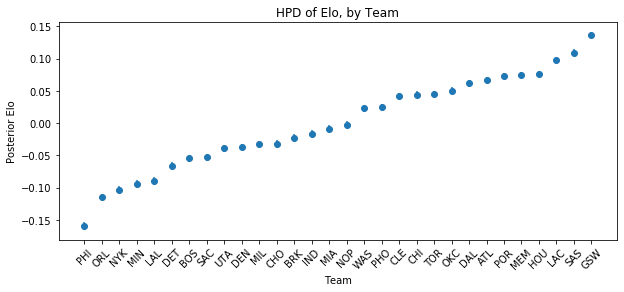

In [113]:
df_hpd = pd.DataFrame(pm.stats.hpd(trace['elo']),
                      columns=['hpd_low', 'hpd_high'],
                      index=teams.team.values)
df_median = pd.DataFrame(pm.stats.quantiles(trace['elo'])[50],
                         columns=['hpd_median'],
                         index=teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median,
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T,
             fmt='o')
axs.set_title('HPD of Elo, by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Elo')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=45)

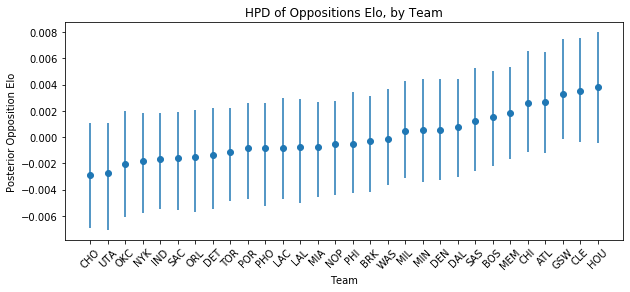

In [114]:
df_hpd = pd.DataFrame(pm.stats.hpd(trace['opp_elo']),
                      columns=['hpd_low', 'hpd_high'],
                      index=teams.team.values)
df_median = pd.DataFrame(pm.stats.quantiles(trace['opp_elo'])[50],
                         columns=['hpd_median'],
                         index=teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median,
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T,
             fmt='o')
axs.set_title('HPD of Oppositions Elo, by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Opposition Elo')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=45)

In [115]:
teams.T

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
team,HOU,ORL,DAL,BRK,MIL,DET,PHI,MIN,WAS,CHI,...,POR,IND,BOS,DEN,TOR,MIA,PHO,SAC,CHO,NOP
i,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29


In [116]:
pm.plot_posterior(trace, varnames=['elo']);

C:\Users\meda.s\AppData\Local\Continuum\anaconda3\lib\site-packages\pymc3\plots\__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


ImportError: ArviZ is not installed. In order to use `plot_posterior`:
pip install arviz

Ugghh!! Arviz why you no install??!! 

Anyways... let's keep going...

In [117]:
with model:
    pp_trace = pm.sample_ppc(trace)

C:\Users\meda.s\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 724.11it/s]


In [118]:
home_sim_df = pd.DataFrame({
    'sim_points_{}'.format(i): 3 * home_won
        for i, home_won in enumerate(pp_trace['home_points'] > pp_trace['away_points'])
})
home_sim_df.insert(0, 'team', df['team_id'])

away_sim_df = pd.DataFrame({
    'sim_points_{}'.format(i): 3 * away_won
        for i, away_won in enumerate(pp_trace['home_points'] < pp_trace['away_points'])
})
away_sim_df.insert(0, 'team', df['opp_id'])

In [119]:
sim_table = (home_sim_df.groupby('team')
                        .sum()
                        .add(away_sim_df.groupby('team')
                                        .sum())
                        .rank(ascending=False, method='min', axis=0)
                        .reset_index()
                        .melt(id_vars='team', value_name='rank')
                        .groupby('team')
                        ['rank']
                        .value_counts()
                        .unstack(level='rank')
                        .fillna(0)
                        .div(1000))

In [120]:
sim_table = sim_table/2
sim_table

rank,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0
team,,,,,,,,,,,,,,,,,,,,,
ATL,0.0,0.5210,0.3280,0.1470,0.0035,0.0005,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
BOS,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.1315,0.2460,0.3415,0.1720,0.0740,0.0000,0.0000,0.0000,0.0000,0.0000
BRK,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0125,0.0020,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
CHI,0.0,0.0005,0.0025,0.0180,0.3540,0.2340,0.1605,0.1080,0.0690,0.0435,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
CHO,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0640,0.0105,0.0025,0.0010,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
CLE,0.0,0.0000,0.0000,0.0010,0.0940,0.1220,0.1535,0.1755,0.1865,0.1705,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
DAL,0.0,0.0000,0.0000,0.0000,0.0030,0.0180,0.0325,0.0510,0.1035,0.1835,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
DEN,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.3605,0.2765,0.1350,0.0420,0.0150,0.0000,0.0000,0.0000,0.0000,0.0000
DET,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0165,0.0675,0.1760,0.3350,0.3980,0.0060,0.0000,0.0000,0.0000,0.0000


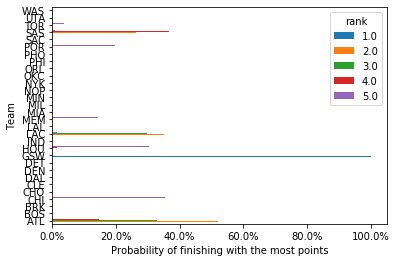

In [121]:
ax = sim_table.loc[:, 1.0:5.0].plot(kind='barh')

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.1%}'));
ax.set_xlabel("Probability of finishing with the most points\n");

ax.set_ylabel("Team");

### So this goes to show and inturn prove the Elo rating System actually works!!

if we see the rank1 column in the table, we notice that GSW has 100% probability of winning the season. Infact they did win!! :O Hat's off to you Professor Elo! The following rank columns in the table show the teams who were most likely to win the league after GSW. Notice how SA Spurs(SAS), Atlanta Hawks(ATL), LA Clippers(LAC) were all close but we had a clear winner..

In [122]:
df_trace = pm.trace_to_dataframe(trace)

## Covariate exploration

Let's finish with some covariates exploration. The covariates here are the team-specific elo strenth parameters as MCMC-sampled from their posterior distribution. Let's see if we can find correlations between elo strengths for all the top teams we thought would win:
CLE: with LeBron James!!
LAC: Lob City!!
ATL: Amazing team plays in that season!
SAS: With coach Greg and Hall of fame player Tim Duncan!
OKC: With KD & Westbrook!

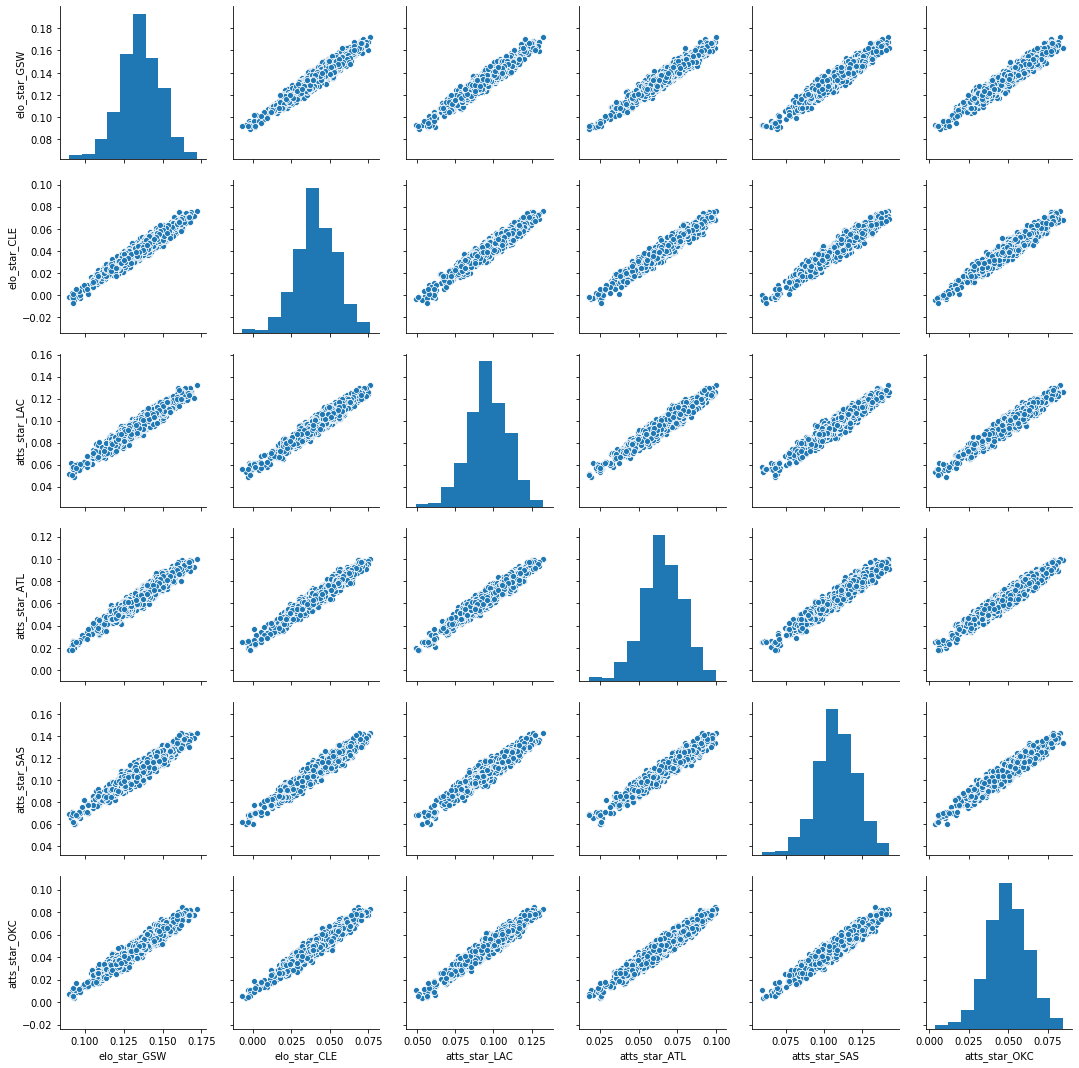

In [124]:
import seaborn as sns

cols = {
    'elo_star__12': 'elo_star_GSW',
    'elo_star__16': 'elo_star_CLE',
    'elo_star__18': 'atts_star_LAC',
    'elo_star__13': 'atts_star_ATL',
    'elo_star__19': 'atts_star_SAS',
    'elo_star__11': 'atts_star_OKC'
}

df_trace_elo = df_trace[list(cols)].rename(columns=cols)
_ = sns.pairplot(df_trace_elo)

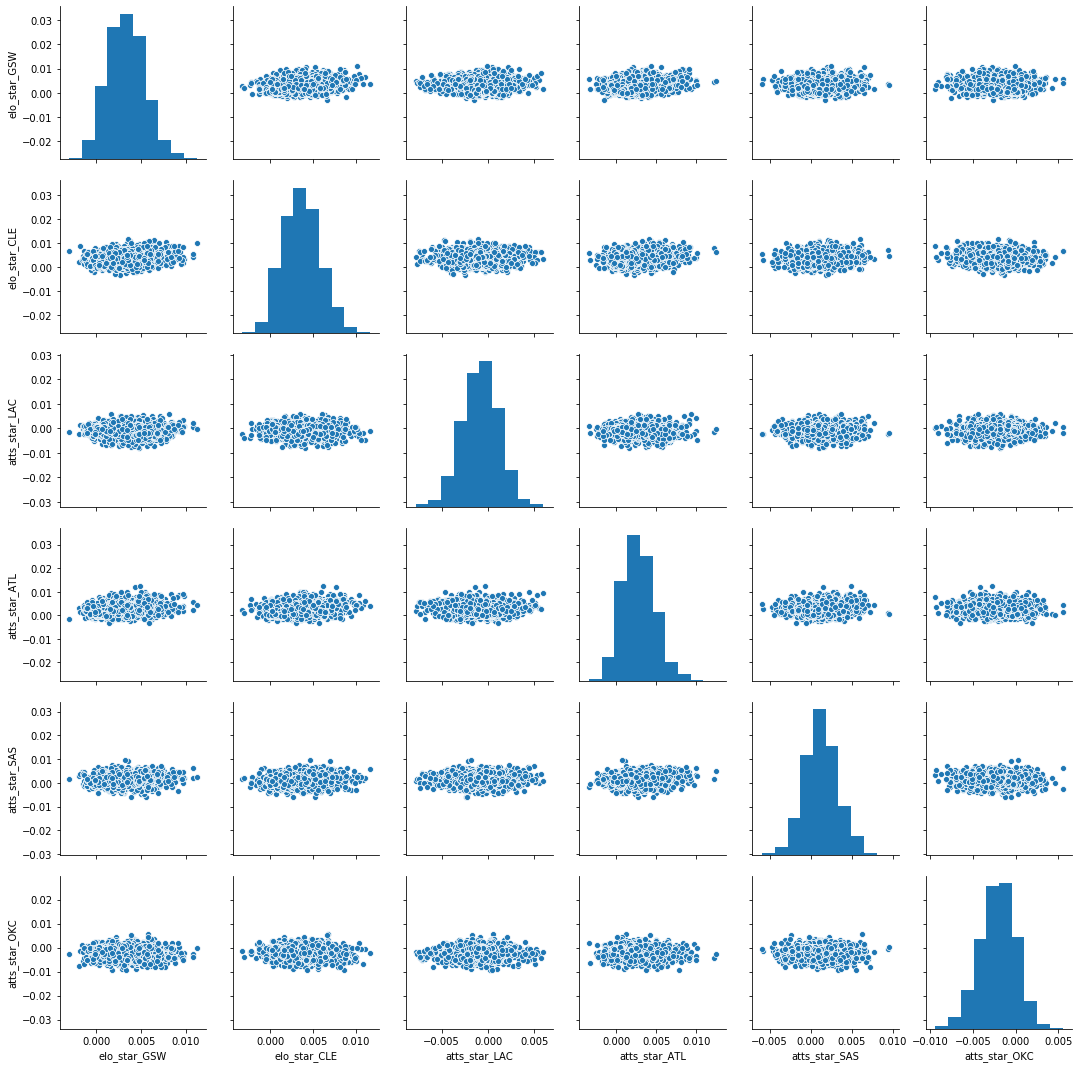

In [125]:
import seaborn as sns

cols = {
    'opp_elo_star__12': 'elo_star_GSW',
    'opp_elo_star__16': 'elo_star_CLE',
    'opp_elo_star__18': 'atts_star_LAC',
    'opp_elo_star__13': 'atts_star_ATL',
    'opp_elo_star__19': 'atts_star_SAS',
    'opp_elo_star__11': 'atts_star_OKC'
}

df_trace_opp_elo = df_trace[list(cols)].rename(columns=cols)
_ = sns.pairplot(df_trace_opp_elo)

Both Team Elo Rating and Opposition Elo Rating covariates appear uncorrelated between teams.

## Elo For The Win!

We were able to *quantify* Team Elo and Opposition Elo strength of NBA teams as parameters of a Bayesian model, together with credibility intervals, with data from NBA 2015.

Our independent variable here is Teams matchy winning capability. Our covariate is Team Elo and Opposition Elo. So we used Elo differentials as a basis to predict... winning teams. That is a just proving that Elo Ratings are true and work in case of basketball games!

So although at first we think Elo is uncorrelated variable to use as a Bayesian linear model for another variable you want to be able to predict, in reality, it actually is a related!